<a href="https://colab.research.google.com/github/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10/blob/main/experiments/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Env**

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10.git
!pip install -r ./Comparative-analysis-of-Generative-models-on-CIFAR-10/requirements.txt

# **Import**

In [172]:
# Imports
import wandb
import sys
import os
import torch
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Add the root directory of the cloned repository to the Python path
sys.path.append('/content/Comparative-analysis-of-Generative-models-on-CIFAR-10')

import importlib
import data.cifar10 as cifar10_module
import utils.checkpointer as checkpointer_module
import train.train as train_module
import models.VAE_models.conv_vae as conv_vae_module
import samplers.vae_sampler as vae_sampler_module
import utils.weight_init as weight_module
import models.VAE_models.vqvae as vqvae_module
import models.VAE_models.pixelcnn as pixelcnn_module
import models.VAE_models.mmdvae as mmdvae_module
import models.VAE_models.conv_vae_res as conv_vae_res_module
import evaluation.eval_functions as eval_module
import models.VAE_models.ncsn as ncsn_module
importlib.reload(cifar10_module)
importlib.reload(checkpointer_module)
importlib.reload(train_module)
importlib.reload(conv_vae_module)
importlib.reload(vae_sampler_module)
importlib.reload(weight_module)
importlib.reload(vqvae_module)
importlib.reload(pixelcnn_module)
importlib.reload(mmdvae_module)
importlib.reload(conv_vae_res_module)
importlib.reload(eval_module)
importlib.reload(ncsn_module)
from data.cifar10 import load_cifar10
from utils.checkpointer import Checkpointer
from train.train import Train
from models.VAE_models.conv_vae import ConvVAE
from samplers.vae_sampler import vae_sample
from utils.weight_init import WeightsInitializer
from models.VAE_models.vqvae import VQVAE
from models.VAE_models.pixelcnn import PixelCNN
from models.VAE_models.mmdvae import MMDVAE
from models.VAE_models.conv_vae_res import ConvVAERes
from evaluation.eval_functions import *
from models.VAE_models.ncsn import NCSN
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# **Load Cifar Data**

In [3]:
train_loader, test_loader = load_cifar10(batch_size=256)

100%|██████████| 170M/170M [00:04<00:00, 35.4MB/s]


In [46]:
import matplotlib.pyplot as plt
from torchvision import transforms

def show_img(img):
    if img.dim() == 4:
        img = img[0]

    img = img.detach().cpu().clamp(0, 1)
    img = img.permute(1, 2, 0)  # CHW -> HWC

    h, w, _ = img.shape
    dpi = 100  # matplotlib default

    # plt.figure(figsize=(w / dpi, h / dpi), dpi=dpi)
    # plt.imshow(img, interpolation='none')  # <- critical

    plt.figure(figsize=(2, 2))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

# **Eval Mmd**

In [173]:
%%capture
model = NCSN().to(device)

In [174]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints_final/ncsn"
checkpointer = Checkpointer(checkpoint_dir,"NCSN",1,False)
train = Train(model,32,train_loader,checkpointer,device)
train.load_checkpoint()
# train.train()

Loaded latest checkpoint: /content/drive/MyDrive/checkpoints_final/ncsn/NCSN_epoch_160.pt


In [163]:
interested_epochs = [112,130,150,160]

In [164]:
train_dataset = train_loader.dataset
def reconstruct_samples(n_samples):
  images = []
  recon_loss = 0.0
  for i in range(1,2+n_samples):
    x_recon, _, _, _ = model(torch.unsqueeze(train_dataset[i][0].to(device),0))
    x_recon = x_recon.detach().cpu()
    x_real = train_dataset[i][0]
    images.append(torch.cat([x_real, x_recon[0]], dim=2))

    recon_loss += F.mse_loss(x_recon[0], x_real, reduction="sum")


  return images, recon_loss/n_samples

In [169]:
def get_samples(n_sample):
  samples = []
  for i in range(n_sample//256):
    samples.append(model.sample(256))

In [177]:
def compute_all(epoch):
  train.load_checkpoint(epoch)
  images = model.sample(16)
  score_samples = get_samples(10000)
  # reconstructed_images, recon_loss = reconstruct_samples(16)
  fid = compute_fid(test_loader,score_samples,device)
  IS = compute_is(score_samples,device)
  # mi = compute_mi(model,test_loader,device)

  return {
              "epoch" : epoch,
              "samples" : images,
              # "recon" : reconstructed_images,
              # "recon_loss" : recon_loss,
              "fid" : fid,
              "is" : IS,
              # "mi" : mi
        }

In [131]:
import os
from datetime import datetime

# Path
save_dir = "/content/drive/MyDrive/scores"
os.makedirs(save_dir, exist_ok=True)

file_path = os.path.join(save_dir, "evaluation.txt")

epoch_data = []


for epoch in interested_epochs:
  print("epoch ",epoch)
  data = compute_all(epoch)
  print(f"epoch {32}")
  print(f"fid {data["fid"]}")
  print(f"is {data["is"]}")
  epoch_data.append(data);


  # Values
  fid_value = data["fid"]
  is_mean, is_std = data["is"]

  # Append to file
  with open(file_path, "a") as f:
      f.write("\n")
      f.write(f"Evaluation Results epoch: {epoch}\n")
      f.write("===================\n")
      f.write(f"Time: {datetime.now()}\n")
      f.write(f"FID: {fid_value:.4f}\n")
      f.write(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}\n")



print(f"Appended results to: {file_path}")




epoch 1
FID:  1
FID:  2
FID:  3
FID:  4
FID:  5
FID:  6
FID:  7
FID:  8
FID:  9
FID:  10
FID:  11
FID:  12
FID:  13
FID:  14
FID:  15
FID:  16
FID:  17
FID:  18
FID:  19
FID:  20
FID:  21
FID:  22
FID:  23
FID:  24
FID:  25
FID:  26
FID:  27
FID:  28
FID:  29
FID:  30
FID:  31
FID:  32
FID:  33
FID:  34
FID:  35
FID:  36
FID:  37
FID:  38
FID:  39


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


epoch 32
fid 124.80101013183594
is (4.138524055480957, 0.11980246007442474)
Saved results to: /content/drive/MyDrive/scores/evaluation.txt


In [ ]:
epoch_data[1]["is"][0]

3.126410722732544

In [71]:
print(data['recon_loss'])

tensor(8.2065)


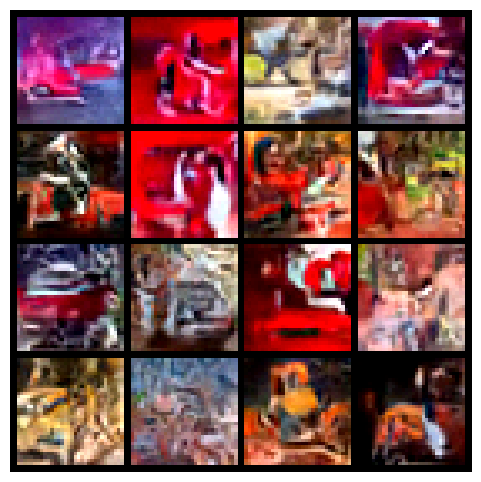

In [132]:
images = data['samples']
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image

# Stack if list
if isinstance(images, list):
    images = torch.stack(images)  # [16, 3, 32, 32]

# Move to CPU and detach (important!)
images = images.detach().cpu()

# Create grid
grid = make_grid(
    images,
    nrow=4,          # 4x4 grid
    padding=2,
    normalize=True
)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

save_image(
    images,
    "NCSN_gen.png",
    nrow=4,
    normalize=True
)

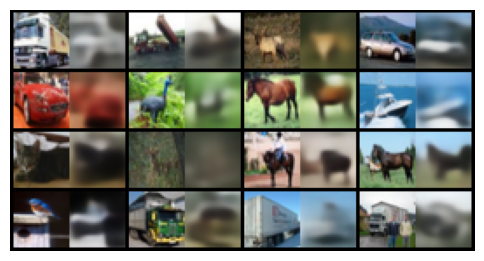

In [109]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image

images = data['recon'][:-1]

# Stack if list
if isinstance(images, list):
    images = torch.stack(images)  # [16, 3, 32, 32]

# Move to CPU and detach (important!)
images = images.detach().cpu()

# Create grid
grid = make_grid(
    images,
    nrow=4,          # 4x4 grid
    padding=2,
    normalize=True
)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

save_image(
    images,
    "convVAERecon1_recon.png",
    nrow=4,
    normalize=True
)

# **Upload to Wandb**

In [44]:
!wandb login

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: azhgh22 (GenBeasts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [110]:
CONFIG = {
    "Name" : "ConvVaeRes1",
    "epochs": 200,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "optimizer_beta1": 0.5,
    "optimizer_beta2": 0.999,
}

wandb.init(project="Comparative-analysis-of-Generative-models-on-CIFAR-10", entity="GenBeasts", name="ConVaeRes1", config=CONFIG)

try:
    for i in range(len(epoch_data)):
      data = epoch_data[i]
      epoch = data["epoch"]
      generated = data["samples"]
      reconstructed = data["recon"]
      recon_loss = data['recon_loss']

      fid = data["fid"]
      IS = data["is"][0]
      mi = data["mi"]

      train.load_checkpoint(epoch)

      losses = train.epoch_losses[-1]

      metrics_to_log = {
          "FID" : fid,
          "IS" : IS,
          "MI" : mi,
          "recon_loss" : recon_loss,
          **losses
        }
      print(f"Logging metrics for epoch {epoch}: {metrics_to_log}") # Debugging print
      wandb.log(metrics_to_log, step=epoch)

      for idx in range(len(generated)):
          print(f"Logging images for epoch {epoch}, idx {idx}") # Debugging print
          wandb.log({
              f"Generated Samples{idx}": wandb.Image(generated[idx], caption=f"Epoch {epoch} Generated {idx}"),
            }, step=epoch)

          wandb.log({
              f"recon images{idx}": wandb.Image(reconstructed[idx], caption=f"Epoch {epoch} Reconstructed {idx}"),
            }, step=epoch)

      model_states = model.state_dict()
      # Save and log monet_generator state dict as a model artifact
      torch.save(model_states, f"{CONFIG['Name']}_{epoch}.pt")
      model_artifact = wandb.Artifact(f"{CONFIG['Name']}", type="model")
      model_artifact.add_file(f"{CONFIG['Name']}_{epoch}.pt")
      print(f"Logging monet_generator artifact for epoch {epoch}") # Debugging print
      wandb.log_artifact(model_artifact, aliases=["latest", f"epoch_{epoch}"])
      os.remove(f"{CONFIG['Name']}_{epoch}.pt") # Clean up local file
finally:
  print("Ensuring wandb.finish() is called.")
  wandb.finish()



Loaded checkpoint for epoch 32: /content/drive/MyDrive/checkpoints_final/ConvVaeResEqual/ConvVaeResEqual_epoch_32.pt
Logging metrics for epoch 32: {'FID': 160.90179443359375, 'IS': 2.9464783668518066, 'MI': 5.532780170440674, 'recon_loss': 77.38700944550183, 'total_loss': 115.42656725280139, 'kl_loss': 38.039557768374074}
Logging images for epoch 32, idx 0
Logging images for epoch 32, idx 1
Logging images for epoch 32, idx 2
Logging images for epoch 32, idx 3
Logging images for epoch 32, idx 4
Logging images for epoch 32, idx 5
Logging images for epoch 32, idx 6
Logging images for epoch 32, idx 7
Logging images for epoch 32, idx 8
Logging images for epoch 32, idx 9
Logging images for epoch 32, idx 10
Logging images for epoch 32, idx 11
Logging images for epoch 32, idx 12
Logging images for epoch 32, idx 13
Logging images for epoch 32, idx 14
Logging images for epoch 32, idx 15
Logging monet_generator artifact for epoch 32
Ensuring wandb.finish() is called.


FID,▁
IS,▁
MI,▁
kl_loss,▁
recon_loss,▁
total_loss,▁
FID,160.90179
IS,2.94648
MI,5.53278
kl_loss,38.03956
recon_loss,77.38701
